# Colapse all simulation into a unique .feather file

In [7]:
import glob, os
import urllib.request, ssl
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

import matplotlib.pyplot as plt
import seaborn as sns
from convergence_analysis import mean_variance_convergence

def download_file(url, local_filename):
    # Create an SSL context that does not verify certificates
    context = ssl._create_unverified_context()
    # Open the URL with the context and read the content
    with urllib.request.urlopen(url, context=context) as response:
        content = response.read()
    # Write the content to the local file
    with open(local_filename, 'wb') as file:
        file.write(content)

def generate_complete_data():
    df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
    if ( os.path.exists(df_complete_file) ):
        print(f'{df_complete_file} already exists. Reading it.')
        df_all = pd.read_feather(df_complete_file)
    else:
        # Concatenate all simulation files
        data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
        df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
        df_all.to_feather('df_complete_ex1.feather')
    return df_all

params_list = ['cycle_tumor_base','necrosis_tumor_base','tumor2motile_base','cycle_motile_base','necrosis_motile_base',
               'cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']

# Define the QoIs: AUC of each population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time: Area under curve (AUC) of the populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over space: Pooling the distances from the center and calculate the Wassertein distance between tumor and tumor motile cells.


In [8]:
# Raw data frame: 1,167,650 rows = 193 samples * 50 repplicates * 121 time points
df_qoi_file = 'df_qoi_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather

def calculate_qoi_summary():
    print(f'{df_summary_file} or {df_qoi_file} does not exist. Generating it.')
    df_all = generate_complete_data()
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        emp_tumor_cdf = ecdf(subgroup['dist_tumor_live'].values[0])
        emp_motile_cdf = ecdf(subgroup['dist_motile_live'].values[0])
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_motile_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_motile_cdf.cdf.probabilities)
        return pd.Series({**auc_values, **wasserstein_values})

    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_dead': ['mean', 'std'], 'AUC_motile_live': ['mean', 'std'], 'AUC_motile_dead': ['mean', 'std'], 'Wasserstein_dist': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)
    
    return df_qoi, df_summary

if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    # Download the summary and qois dataframes 
    print("Downloading summary and qois dataframes...")
    url_qois = "https://zenodo.org/records/14590312/files/df_qoi_ex1.feather?download=1"
    url_summary = "https://zenodo.org/records/14590312/files/df_summary_ex1.feather?download=1"
    # Create an SSL context that does not verify certificates
    context = ssl._create_unverified_context()
    download_file(url_qois, df_qoi_file)
    download_file(url_summary, df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
    df_summary = pd.read_feather(df_summary_file)
    print("Dataframes downloaded.")
    # df_qoi, df_summary = calculate_qoi_summary()
    

print(df_qoi.shape)
print(df_summary.shape)
df_summary

Dataframes downloaded.
(9650, 31)
(193, 35)


,sample,AUC_tumor_live_mean,AUC_tumor_live_std,AUC_tumor_dead_mean,AUC_tumor_dead_std,AUC_motile_live_mean,AUC_motile_live_std,AUC_motile_dead_mean,AUC_motile_dead_std,Wasserstein_dist_mean,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12599872.8,116226.481580,2577283.2,82903.983544,1609754.4,54394.713622,878388.6,63023.645385,119.101705,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
1,1,12566227.2,114297.665983,2568325.8,60793.441311,1595599.2,58689.117471,867574.8,68904.424497,116.733460,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
2,2,12626206.8,183060.372761,2577936.0,71730.670240,1618795.8,72014.418712,889663.2,61761.456425,118.669388,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
3,3,12546777.6,163867.722022,2548109.4,72369.317983,1584557.4,58545.271365,871987.8,64394.402637,117.502375,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
4,4,12625597.8,164921.787973,2590981.2,96639.788097,1608911.4,64826.358837,888713.4,57028.311322,117.269028,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,12603148.8,149210.095307,2561312.4,75184.198094,1639434.6,60838.213562,875599.2,76444.551276,118.999942,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.4
189,189,12626967.6,113817.214662,2586513.0,59900.186339,1570371.0,49586.715603,861663.0,63764.228352,115.344907,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.2
190,190,12547218.0,141977.212199,2533656.6,75920.373959,1651852.2,70560.787899,904120.8,53342.936064,119.033725,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.8
191,191,12697405.8,158066.920446,2632551.0,81309.140743,1548094.2,59991.939870,832729.2,55393.937849,114.366868,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,6.4


Sample with reference parameters:  [7.20e-04 2.80e-03 1.00e-03 7.20e-04 2.80e-03 7.20e-03 2.15e+01 4.00e+00
 2.50e-01 3.00e+00 3.75e+00 8.00e+00 6.75e+00 8.00e+00 7.20e-03 2.15e+01
 4.00e+00 2.50e-01 3.00e+00 3.75e+00 8.00e+00 5.00e-03 6.75e+00 8.00e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


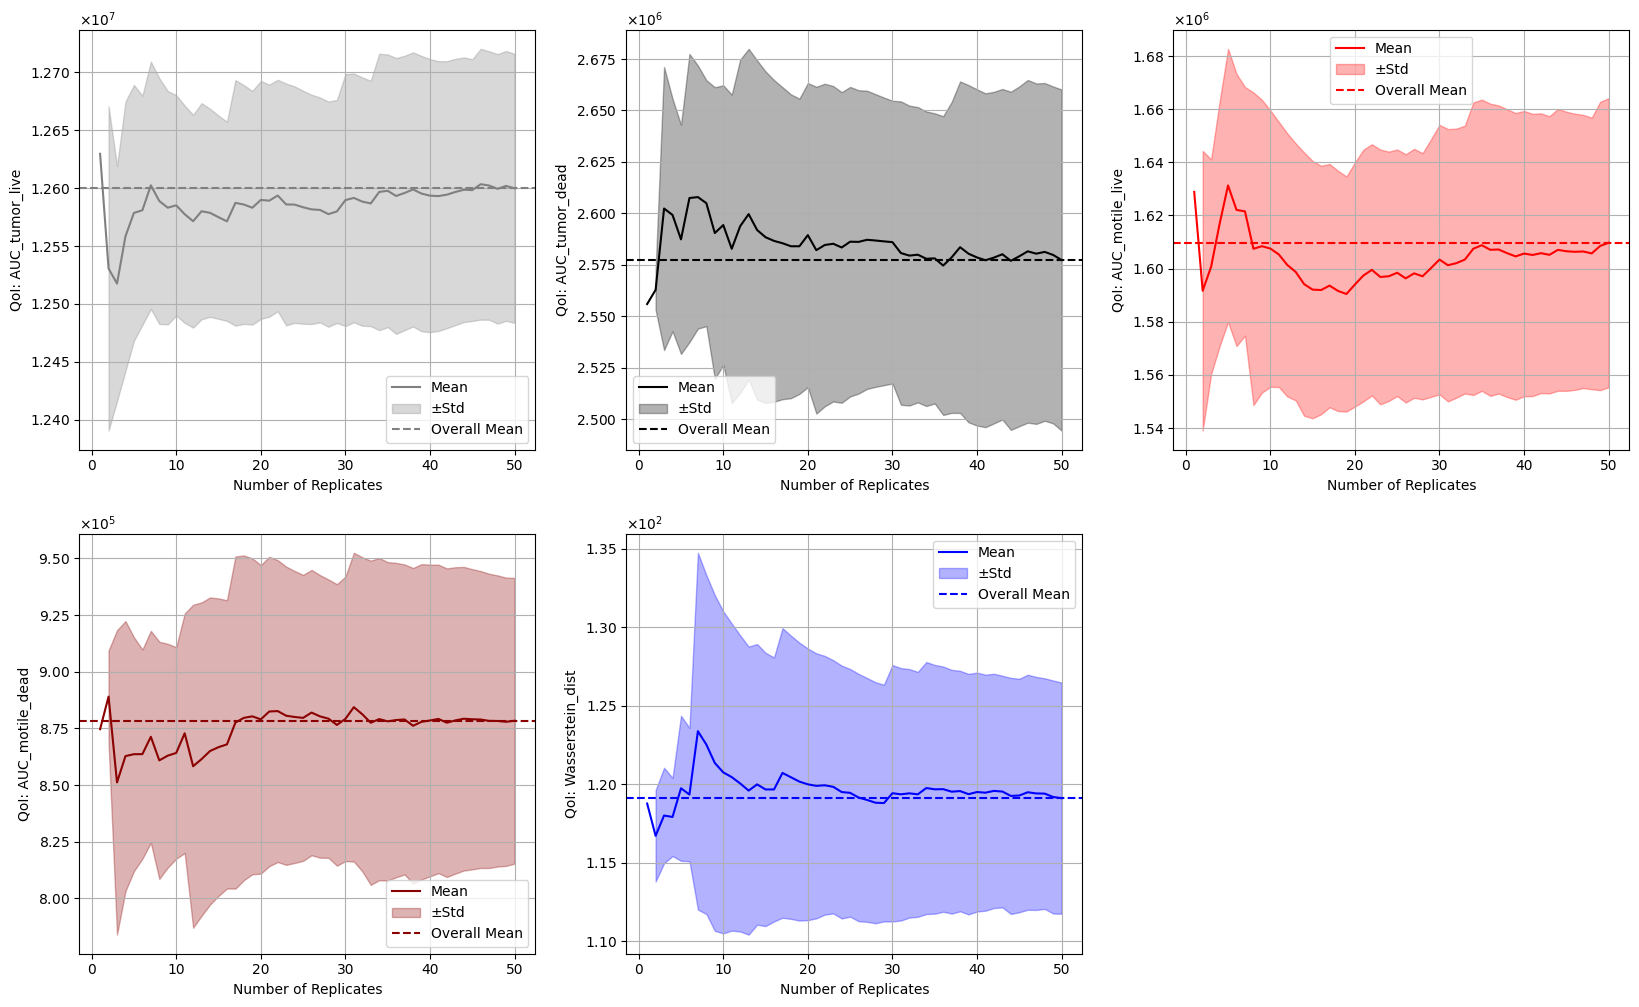

In [9]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_motile_live', 'AUC_motile_dead', 'Wasserstein_dist']
colors = ['gray', 'black', 'red', 'darkred', 'blue']
figure1, axes = plt.subplots(2, 3, figsize=(20, 12))
for qoi, color, ax in zip(QoIs_list, colors, axes.flatten()):
    data = df_qoi.loc[ df_qoi['sample'] == sample_ref][qoi].values
    # Calculate running mean and variance for the QoI
    running_means, running_var = mean_variance_convergence(data)
    running_stds = np.sqrt(running_var)
    # Plot the running mean and standard deviation
    x = np.arange(1, len(data) + 1)
    ax.plot(x, running_means, label='Mean', color=color)
    ax.fill_between(x, running_means - running_stds, running_means + running_stds, alpha=0.3, label='±Std', color=color)
    ax.axhline(np.mean(data), color=color, linestyle='--', label='Overall Mean')
    ax.set_xlabel('Number of Replicates')
    ax.set_ylabel(f'QoI: {qoi}')
    # ax.set_title(f'Convergence of QoI ({qoi}) Across Replicates')
    ax.grid()
    ax.legend()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
axes[1, 2].remove()
plt.show()
figure1.savefig('Replicates_hypoxia.svg', format='svg')


# Local sensitivity analysis: 
Given $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Sensitivity index:

$$\overline{SI}_{\theta_i} = \dfrac{||f(\theta_i)-f(\theta^\star)||}{\max_\delta ||f(\theta_i)-f(\theta^\star)||}$$

- $\overline{SI}_{\theta_i}=0:$ The output is insensitive to changes in the parameter.
- $\overline{SI}_{\theta_i}=1:$ The output is highly sensitive to the parameter; $\theta_i$ has the maximum impact on the QoIs compared to all other parameters and perturbations.

Interpretation:
- High $\overline{SI}_{\theta_i}$ values (closer to 1) suggest that the parameter $\theta_i$ is influential and significantly impacts the model outputs. Such parameters may require precise calibration or careful validation based on experimental or clinical data.
- Low $\overline{SI}_{\theta_i}$ values (closer to 0) indicate that the parameter $\theta_i$ has little to no effect on the QoIs. These parameters may have limited importance in the model's behavior within the tested range and could be candidates for simplification or fixed values.

In [10]:
# Calculate the sensitivity index accross all perturbation levels
QoIs_list = [qoi+'_mean' for qoi in QoIs_list]
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(0); non_zero_params.append('Reference'); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs - normalize the difference by the maximum difference
    absolute_change_qois = abs(df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values)
    max_diff_qois = absolute_change_qois.max()
    normalized_change_qois = absolute_change_qois / max_diff_qois
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = normalized_change_qois.to_numpy()[:,id_qoi]

    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: Sample {int(sample_lowest_qoi)} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and Sample {int(sample_highest_qoi)} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: Sample {int(sample_lowest_si)} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and Sample {int(sample_highest_si)} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

QoI: AUC_tumor_live_mean
	 lowest and highest QoI: Sample 184 (motile2tumor_hfm) and Sample 55 (cycle_tumor_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 55 (cycle_tumor_hfm)

QoI: AUC_tumor_dead_mean
	 lowest and highest QoI: Sample 87 (necrosis_tumor_hfm) and Sample 88 (necrosis_tumor_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 88 (necrosis_tumor_hfm)

QoI: AUC_motile_live_mean
	 lowest and highest QoI: Sample 103 (tumor2motile_hfm) and Sample 184 (motile2tumor_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 184 (motile2tumor_hfm)

QoI: AUC_motile_dead_mean
	 lowest and highest QoI: Sample 159 (necrosis_motile_hfm) and Sample 160 (necrosis_motile_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 160 (necrosis_motile_hfm)

QoI: Wasserstein_dist_mean
	 lowest and highest QoI: Sample 183 (motile2tumor_hfm) and Sample 103 (tumor2motile_hfm)
	 lowest and highest SI: Sample 0 (Reference) and Sample 103 (tumor2motile_hfm)



,sample,SA_parameter,SA_delta,SI_AUC_tumor_live_mean,SI_AUC_tumor_dead_mean,SI_AUC_motile_live_mean,SI_AUC_motile_dead_mean,SI_Wasserstein_dist_mean
0,0,Reference,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,cycle_tumor_base,-0.01,0.033599,0.005401,0.019402,0.014568,0.120741
2,2,cycle_tumor_base,0.01,0.026297,0.000394,0.012393,0.015189,0.022041
3,3,cycle_tumor_base,-0.05,0.053021,0.017592,0.034536,0.008623,0.081539
4,4,cycle_tumor_base,0.05,0.025689,0.008260,0.001155,0.013909,0.093436
...,...,...,...,...,...,...,...,...
188,188,motile2tumor_hp,0.05,0.003271,0.009631,0.040681,0.003758,0.005188
189,189,motile2tumor_hp,-0.10,0.027057,0.005566,0.053981,0.022532,0.191534
190,190,motile2tumor_hp,0.10,0.052581,0.026308,0.057702,0.034665,0.003466
191,191,motile2tumor_hp,-0.20,0.097397,0.033327,0.084515,0.061511,0.241398


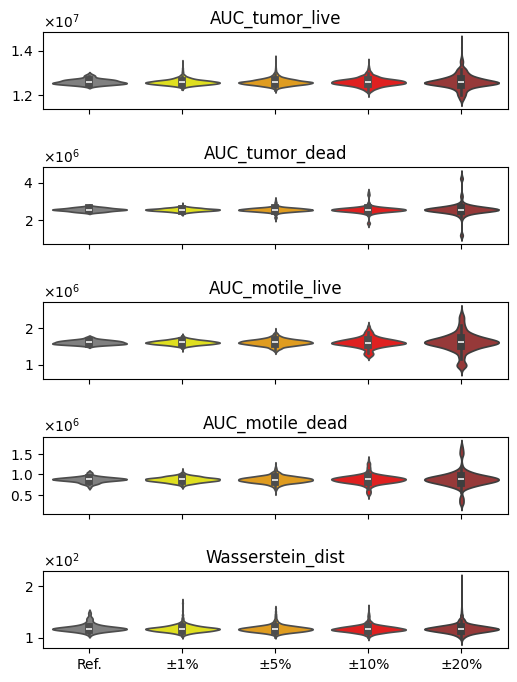

In [11]:
fig, axes = plt.subplots(5, 1, figsize=(6, 8), sharex=True)

plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[(df_SA['SA_delta'] == delta) | (df_SA['SA_delta'] == -1*delta)]['sample'].values
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    # change the x ticks label adding +- sign
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Ref.', '±1%', '±5%', '±10%', '±20%'])
    ax.set_title(qoi[:-5])
    # ax.set_xlabel('multiplicative perturbation')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()
fig.savefig('QoIs_hypoxia.svg', format='svg')

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_17786/1197059089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA['SA_delta'] = df_SA['SA_delta']*100


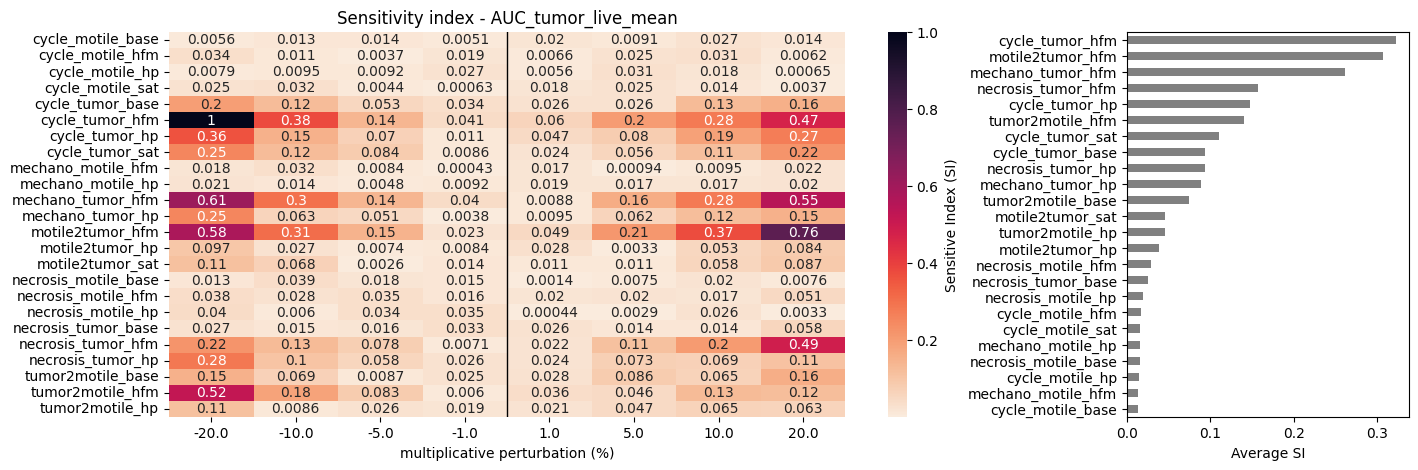

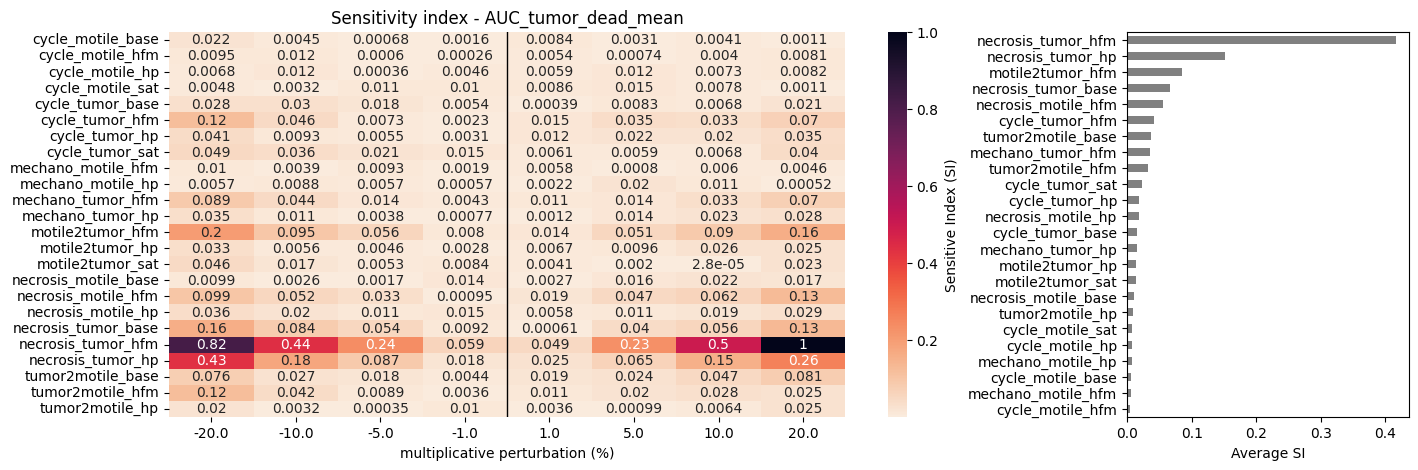

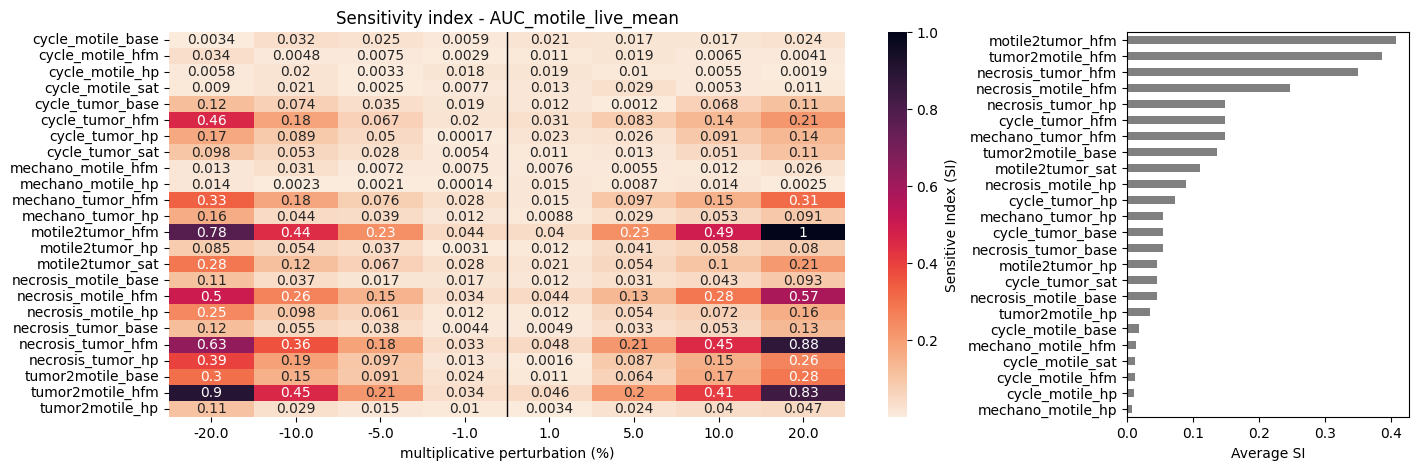

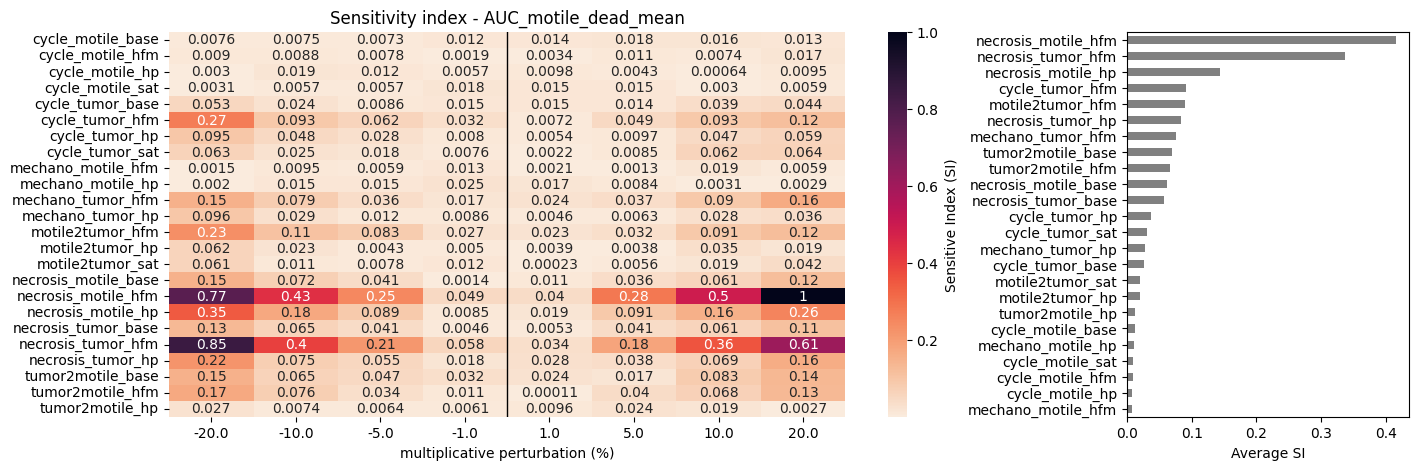

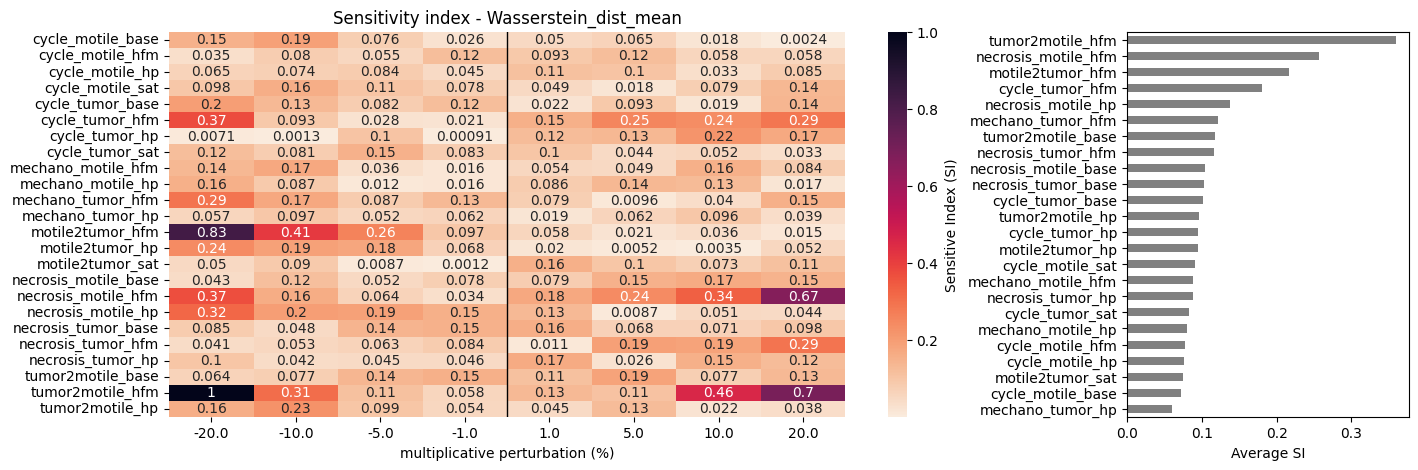

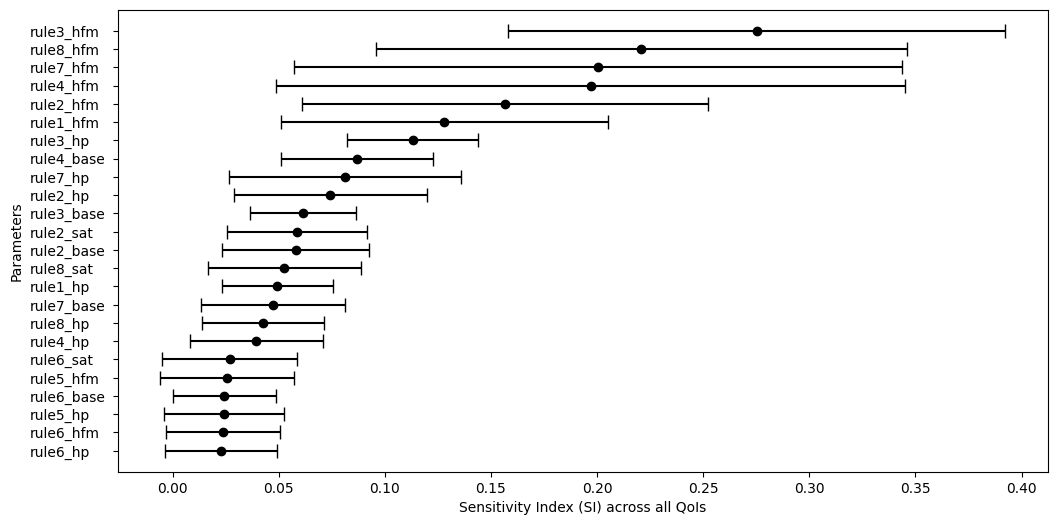

In [12]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the multiplicative perturbation to percentage
df_SA['SA_delta'] = df_SA['SA_delta']*100
dict_SI = {}
# Plot the parameter according to the sensitivity index as heatmap with the parameters vs delta perturbation and color as the SI
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
    df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    # print(df_SA_pivot.head(),'\n')
    sns.heatmap(df_SA_pivot_plot, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label('Sensitive Index (SI)')
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    ax1.set(title = f'Sensitivity index - {qoi}', xlabel='multiplicative perturbation (%)', ylabel=None)
    # Average the RSI across all multiplicative perturbations
    dict_SI[qoi] = df_SA_pivot_plot.mean(axis=1)
    dict_SI[qoi] = dict_SI[qoi].sort_values(ascending=True)
    dict_SI[qoi].plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average SI', ylabel=None)
plt.show()

fig2, ax = plt.subplots(figsize=(12, 6))
# 
# Merge the sensitivity index of all QoIs and plot the average SI and std
df_SI = pd.DataFrame(dict_SI)
df_SI['mean'] = df_SI.mean(axis=1)
df_SI['std'] = df_SI.std(axis=1)
df_SI = df_SI.sort_values(by='mean', ascending=True)
# rename the indeces to the parameter names
dic_ref_rules = {'mechano_tumor': 'rule1', 'cycle_tumor': 'rule2', 'necrosis_tumor': 'rule3', 'tumor2motile': 'rule4', 'mechano_motile': 'rule5', 'cycle_motile': 'rule6', 'necrosis_motile': 'rule7', 'motile2tumor': 'rule8'}
for index in df_SI.index:
    for key, value in dic_ref_rules.items():
        if key in index: df_SI.rename(index={index: index.replace(key, value)}, inplace=True)
ax.errorbar(df_SI['mean'], df_SI.index, xerr=df_SI['std'], fmt='o', color='k', capsize=5)
ax.set(xlabel='Sensitivity Index (SI) across all QoIs', ylabel='Parameters')
# Adjust y-tick labels to align left
ax.set_yticks(range(len(df_SI.index)))  # Ensure correct y-tick positions
ax.set_yticklabels(df_SI.index, ha='left')  # Align labels to the left
ax.tick_params(axis='y', pad=60)  # Adjust padding to move labels closer to the margin

plt.show()
fig2.savefig('SI_params_hypoxia.svg', format='svg')